In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import math
from torch.utils.data import random_split
import time
from torch.utils.tensorboard import SummaryWriter
import os

In [2]:
myTransform = transforms.Compose([
    #resize de-activated to use SimpleNet
    
    #transforms.Resize((227,227)),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 100, dropout: float = 0.5):
        super().__init__()
        self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(64, 192, kernel_size=5, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(192, 384, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(384, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(256 * 6 * 6, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout),
                nn.Linear(4096, 1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024, num_classes),
            )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
class AlexNet_mod(nn.Module):
    def __init__(self, num_classes: int = 100, dropout: float = 0.5):
        super().__init__()
        self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(64, 192, kernel_size=5, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(192, 384, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(384, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(256 * 6 * 6, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout),
                nn.Linear(4096, 1024),
                nn.Sigmoid(),
                nn.Linear(1024, num_classes),
            )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [5]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
class ArgObj(object):
    _defaults = {
        "max_epochs": 100,
        "patience": 3,
        "device": "cuda",
        "seed": 42,
        "lr": 0.01,
        "momentum": 0.7,
        "batch_size": 32,
        "n_classes": 100,
        "dropout": 0.5,
        "log_interval": 10,
    }

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults)
        self.__dict__.update(kwargs)


my_args = ArgObj()

print(vars(my_args))

{'max_epochs': 100, 'patience': 3, 'device': 'cuda', 'seed': 42, 'lr': 0.01, 'momentum': 0.7, 'batch_size': 32, 'n_classes': 100, 'dropout': 0.5, 'log_interval': 10}


In [7]:
train_dataset = torchvision.datasets.CIFAR100(root='./root', train=True,
                                              transform=myTransform, download=True)
test_val_dataset = torchvision.datasets.CIFAR100(root='./root', train=False,
                                              transform=myTransform, download=True) 

gnr = torch.Generator().manual_seed(my_args.seed)
test_dataset, val_dataset = random_split(test_val_dataset, [0.5, 0.5], generator=gnr)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=my_args.batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=my_args.batch_size, shuffle=False)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=my_args.batch_size, shuffle=False)

examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./root/cifar-100-python.tar.gz to ./root
Files already downloaded and verified
torch.Size([32, 3, 32, 32]) torch.Size([32])


In [8]:
def create_superclass(x):
    fine_id_coarse_id = {0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3, 10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11, 16: 3, 17: 9, 18: 7, 19: 11, 20: 6, 21: 11, 22: 5, 23: 10, 24: 7, 25: 6, 26: 13, 27: 15, 28: 3, 29: 15, 30: 0,
                         31: 11, 32: 1, 33: 10, 34: 12, 35: 14, 36: 16,
                         37: 9, 38: 11, 39: 5, 40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13, 46: 14, 47: 17, 48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2, 55: 0, 56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12, 64: 12, 65: 16,
                         66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10, 72: 0, 73: 1, 74: 16,
                         75: 12, 76: 9, 77: 13, 78: 15, 79: 13, 80: 16, 81: 19, 82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5, 88: 8, 89: 19, 90: 18, 91: 1, 92: 2, 93: 15, 94: 6, 95: 0, 96: 17, 97: 8, 98: 14, 99: 13}
    return fine_id_coarse_id[x]


v_create_superclass = np.vectorize(create_superclass)


def create_ultraclass(x):
    coarse_id_ultra_id = {0: 0, 1: 4, 2: 1, 3: 2, 4: 1, 5: 2, 6: 2, 7: 3, 8: 4, 9: 6, 10: 6, 11: 4, 12: 0, 13: 3, 14: 0, 15: 4, 16: 0, 17: 6, 18: 5, 19: 5}
    return coarse_id_ultra_id[x]


v_create_ultraclass = np.vectorize(create_ultraclass)


def get_labels(idx, level='super'):
    labels = {
        'ultra': ['mammal', 'plant', 'household', 'invertebrates', 'other animal', 'vehicles', 'nature'],

        'super': ['aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit & vegetables',
                  'household electrical device', 'household furniture', 'insects', 'large carnivores',
                  'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores',
                  'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2'
                  ],
        'sub': [
            'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
            'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
            'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
            'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
            'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
            'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
            'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
            'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
            'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
            'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
            'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
            'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
            'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
            'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
            'worm'
        ]
    }
    return labels[level][idx]

In [9]:
examples = iter(train_loader)
samples, labels = next(examples)

sup = v_create_superclass(labels)
ult = v_create_ultraclass(sup)

levels = [labels, sup, ult]
level_names = ["sub", "super", "ultra"]

for i in range(len(labels)):
    for j in range(3):
        a = levels[j][i]
        print(get_labels(a, level=level_names[j]), end=" | ")
    print("\n")

rocket | vehicles 2 | vehicles | 

dolphin | aquatic mammals | mammal | 

woman | people | mammal | 

tank | vehicles 2 | vehicles | 

otter | aquatic mammals | mammal | 

fox | medium-sized mammals | mammal | 

cloud | large natural outdoor scenes | nature | 

apple | fruit & vegetables | plant | 

sunflower | flowers | plant | 

cup | food containers | household | 

shrew | small mammals | mammal | 

leopard | large carnivores | other animal | 

rabbit | small mammals | mammal | 

lobster | non-insect invertebrates | invertebrates | 

otter | aquatic mammals | mammal | 

bottle | food containers | household | 

orchid | flowers | plant | 

castle | large man-made outdoor things | nature | 

pear | fruit & vegetables | plant | 

willow_tree | trees | nature | 

woman | people | mammal | 

otter | aquatic mammals | mammal | 

dolphin | aquatic mammals | mammal | 

spider | non-insect invertebrates | invertebrates | 

shark | fish | other animal | 

rocket | vehicles 2 | vehicles | 

or

In [10]:
labs = range(100)

#sorted by index - ultra class first key, superclass second
sorted_labels = sorted(labs, key= lambda x: (create_ultraclass(create_superclass(x)), create_superclass(x)))

for i in sorted_labels:
    print(f"{get_labels(i, 'sub')}|{get_labels(create_superclass(i), 'super')}|{get_labels(create_ultraclass(create_superclass(i)), 'ultra')}")

beaver|aquatic mammals|mammal
dolphin|aquatic mammals|mammal
otter|aquatic mammals|mammal
seal|aquatic mammals|mammal
whale|aquatic mammals|mammal
fox|medium-sized mammals|mammal
porcupine|medium-sized mammals|mammal
possum|medium-sized mammals|mammal
raccoon|medium-sized mammals|mammal
skunk|medium-sized mammals|mammal
baby|people|mammal
boy|people|mammal
girl|people|mammal
man|people|mammal
woman|people|mammal
hamster|small mammals|mammal
mouse|small mammals|mammal
rabbit|small mammals|mammal
shrew|small mammals|mammal
squirrel|small mammals|mammal
orchid|flowers|plant
poppy|flowers|plant
rose|flowers|plant
sunflower|flowers|plant
tulip|flowers|plant
apple|fruit & vegetables|plant
mushroom|fruit & vegetables|plant
orange|fruit & vegetables|plant
pear|fruit & vegetables|plant
sweet_pepper|fruit & vegetables|plant
bottle|food containers|household
bowl|food containers|household
can|food containers|household
cup|food containers|household
plate|food containers|household
clock|household el

In [11]:
ult = v_create_ultraclass(v_create_superclass(sorted_labels))

for i in np.unique(ult):
    print(f'{get_labels(i, "ultra"):<10} \t {list(ult).count(i):>10}\n____________________________')

mammal     	         20
____________________________
plant      	         10
____________________________
household  	         15
____________________________
invertebrates 	         10
____________________________
other animal 	         20
____________________________
vehicles   	         10
____________________________
nature     	         15
____________________________


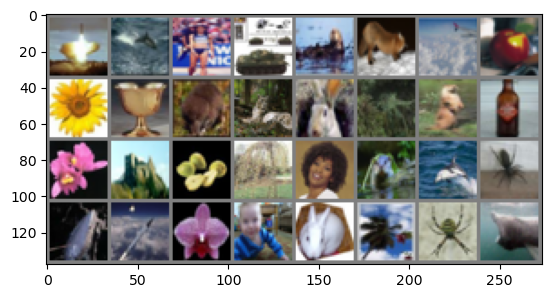

rocket | dolphin | woman | tank  | otter | fox   | cloud | apple
sunflower | cup   | shrew | leopard | rabbit | lobster | otter | bottle
orchid | castle | pear  | willow_tree | woman | otter | dolphin | spider
shark | rocket | orchid | baby  | rabbit | palm_tree | spider | shark



In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(samples))
# print labels

def line_break(x):
    return [' | ', "\n"][(x+1) % 8 == 0 and x>0]
    
print(''.join(f'{get_labels(labels[i], "sub"):5s}{line_break(i)}' for i in range(len(labels))))

In [13]:
criterion_mean = nn.CrossEntropyLoss(reduction='mean')
criterion_sum = nn.CrossEntropyLoss(reduction='sum')

In [14]:
def train_epoch_cnn(model, train_loader, optimizer, args):

    model.train()  # set model to training mode (activate dropout layers for example)
    t = time.time() # we measure the needed time
    for batch_idx, (data, target) in enumerate(train_loader):  # iterate over training data
        data, target = data.to(args.device), target.to(args.device)  # move data to device (GPU) if necessary
        optimizer.zero_grad()  # reset optimizer
        output = model(data)   # forward pass: calculate output of network for input
        loss = criterion_mean(output, target)  # calculate loss
        loss.backward()  # backward pass: calculate gradients using automatic diff. and backprop.
        optimizer.step()  # udpate parameters of network using our optimizer
        cur_time = time.time()
        # print some outputs if we reached our logging intervall
        if cur_time - t > args.log_interval or batch_idx == len(train_loader)-1:
            print(f"[{batch_idx * len(data):2f}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tloss: {loss.item():.6f}, took {cur_time - t:.2f}s")
            t = cur_time

def test_cnn(model, test_loader, args):

    model.eval()  # set model to inference mode (deactivate dropout layers for example)
    test_loss = 0  # init overall loss
    correct = 0
    total = 0
    
    with torch.no_grad():  # do not calculate gradients since we do not want to do updates
        
        for data, target in test_loader:  # iterate over test data
            data, target = data.to(args.device), target.to(args.device)  # move data to device 
            output = model(data) # forward pass
            # claculate loss and add it to our cumulative loss
            test_loss += criterion_sum(output, target).item()
            
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
    test_loss /= len(test_loader.dataset)  # calc mean loss
    test_acc = (100 * correct / total)
    
    print('Average eval loss: {:.4f}'.format(test_loss, len(test_loader.dataset)))
    print('Eval accuracy: {:.4f}%\n'.format(test_acc))
    return test_loss


def inference_cnn(model, data, args):
    model.eval()   # set model to inference mode
    in_shape = data.shape
    side = int((args.context - 1) / 2)
    outlen = in_shape[0] - 2 * side
    output = np.zeros((in_shape[0], args.out_num))
    data = torch.from_numpy(data[None, :, :]) 
    data = data.to(args.device) # move input to device
    with torch.no_grad(): # do not calculate gradients
        for idx in range(outlen): # iterate over input data
            # calculate output for input data (and move back from device)
            output[idx+side, :] = model(data[:, idx:(idx + args.context), :])[0, :].cpu()
    return output

In [15]:
def train_cnn(smoke_test=False, load_model=False, args=my_args, model_arg=AlexNet()):
    
    if smoke_test:
        max_epochs = 5
    else:
        max_epochs = args.max_epochs

    torch.manual_seed(args.seed)
    device = args.device
    
    model = model_arg.to(device)
    
    from torch.optim import SGD
    optimizer = SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    #kwargs = {'num_workers': 2, 'pin_memory': True}

    best_valid_loss = 9999.
    cur_patience = args.patience
    print('Training CNN...')
    start_t = time.time()
    
    for epoch in range(1,max_epochs):
        print(f"Epoch: {epoch}")
        print(f"Best validation loss: {best_valid_loss:.4f}")
        print(f"Patience: {cur_patience}")

        train_epoch_cnn(model, train_loader, optimizer, args)
        
        cur_valid_loss = test_cnn(model, val_loader, args)
        
        if cur_valid_loss<best_valid_loss:
            best_valid_loss = cur_valid_loss
            cur_patience = args.patience
        else: 
            cur_patience-=1
            if cur_patience <= 0: 
                print(f"Best validation loss: {best_valid_loss:.4f}")
                break
    
    print('Trainig took: {:.2f}s for {} epochs'.format(time.time()-start_t, epoch))
    print('Testing...')
    test_loss = test_cnn(model, test_loader, args)
    
    return model

In [16]:
trained_model1 = train_cnn(smoke_test=False, model_arg=SimpleNet())

Training CNN...
Epoch: 1
Best validation loss: 9999.0000
Patience: 3
[18560.000000/50000 (37%)]	loss: 4.590748, took 10.00s
[24992.000000/50000 (100%)]	loss: 4.123691, took 9.40s
Average eval loss: 4.3230
Eval accuracy: 4.2400%

Epoch: 2
Best validation loss: 4.3230
Patience: 3
[33824.000000/50000 (68%)]	loss: 3.872668, took 10.00s
[24992.000000/50000 (100%)]	loss: 4.026879, took 4.71s
Average eval loss: 3.8378
Eval accuracy: 11.3400%

Epoch: 3
Best validation loss: 3.8378
Patience: 3
[32928.000000/50000 (66%)]	loss: 3.514789, took 10.01s
[24992.000000/50000 (100%)]	loss: 3.134752, took 4.98s
Average eval loss: 3.5683
Eval accuracy: 16.6400%

Epoch: 4
Best validation loss: 3.5683
Patience: 3
[34560.000000/50000 (69%)]	loss: 3.477195, took 10.01s
[24992.000000/50000 (100%)]	loss: 3.712038, took 4.35s
Average eval loss: 3.3409
Eval accuracy: 20.1600%

Epoch: 5
Best validation loss: 3.3409
Patience: 3
[33056.000000/50000 (66%)]	loss: 3.323541, took 10.01s
[24992.000000/50000 (100%)]	loss:

In [17]:
trained_model2 = train_cnn(smoke_test=False, model_arg=SimpleNet())

Training CNN...
Epoch: 1
Best validation loss: 9999.0000
Patience: 3
[33984.000000/50000 (68%)]	loss: 4.609777, took 10.01s
[24992.000000/50000 (100%)]	loss: 3.894595, took 4.64s
Average eval loss: 4.1877
Eval accuracy: 6.3000%

Epoch: 2
Best validation loss: 4.1877
Patience: 3
[34816.000000/50000 (70%)]	loss: 3.895574, took 10.01s
[24992.000000/50000 (100%)]	loss: 3.998951, took 4.83s
Average eval loss: 3.7254
Eval accuracy: 13.6200%

Epoch: 3
Best validation loss: 3.7254
Patience: 3
[34272.000000/50000 (69%)]	loss: 3.208439, took 10.01s
[24992.000000/50000 (100%)]	loss: 3.331725, took 4.55s
Average eval loss: 3.4961
Eval accuracy: 16.9800%

Epoch: 4
Best validation loss: 3.4961
Patience: 3
[34624.000000/50000 (69%)]	loss: 3.963616, took 10.00s
[24992.000000/50000 (100%)]	loss: 3.487249, took 5.00s
Average eval loss: 3.3147
Eval accuracy: 20.7600%

Epoch: 5
Best validation loss: 3.3147
Patience: 3
[34528.000000/50000 (69%)]	loss: 3.231678, took 10.01s
[24992.000000/50000 (100%)]	loss:

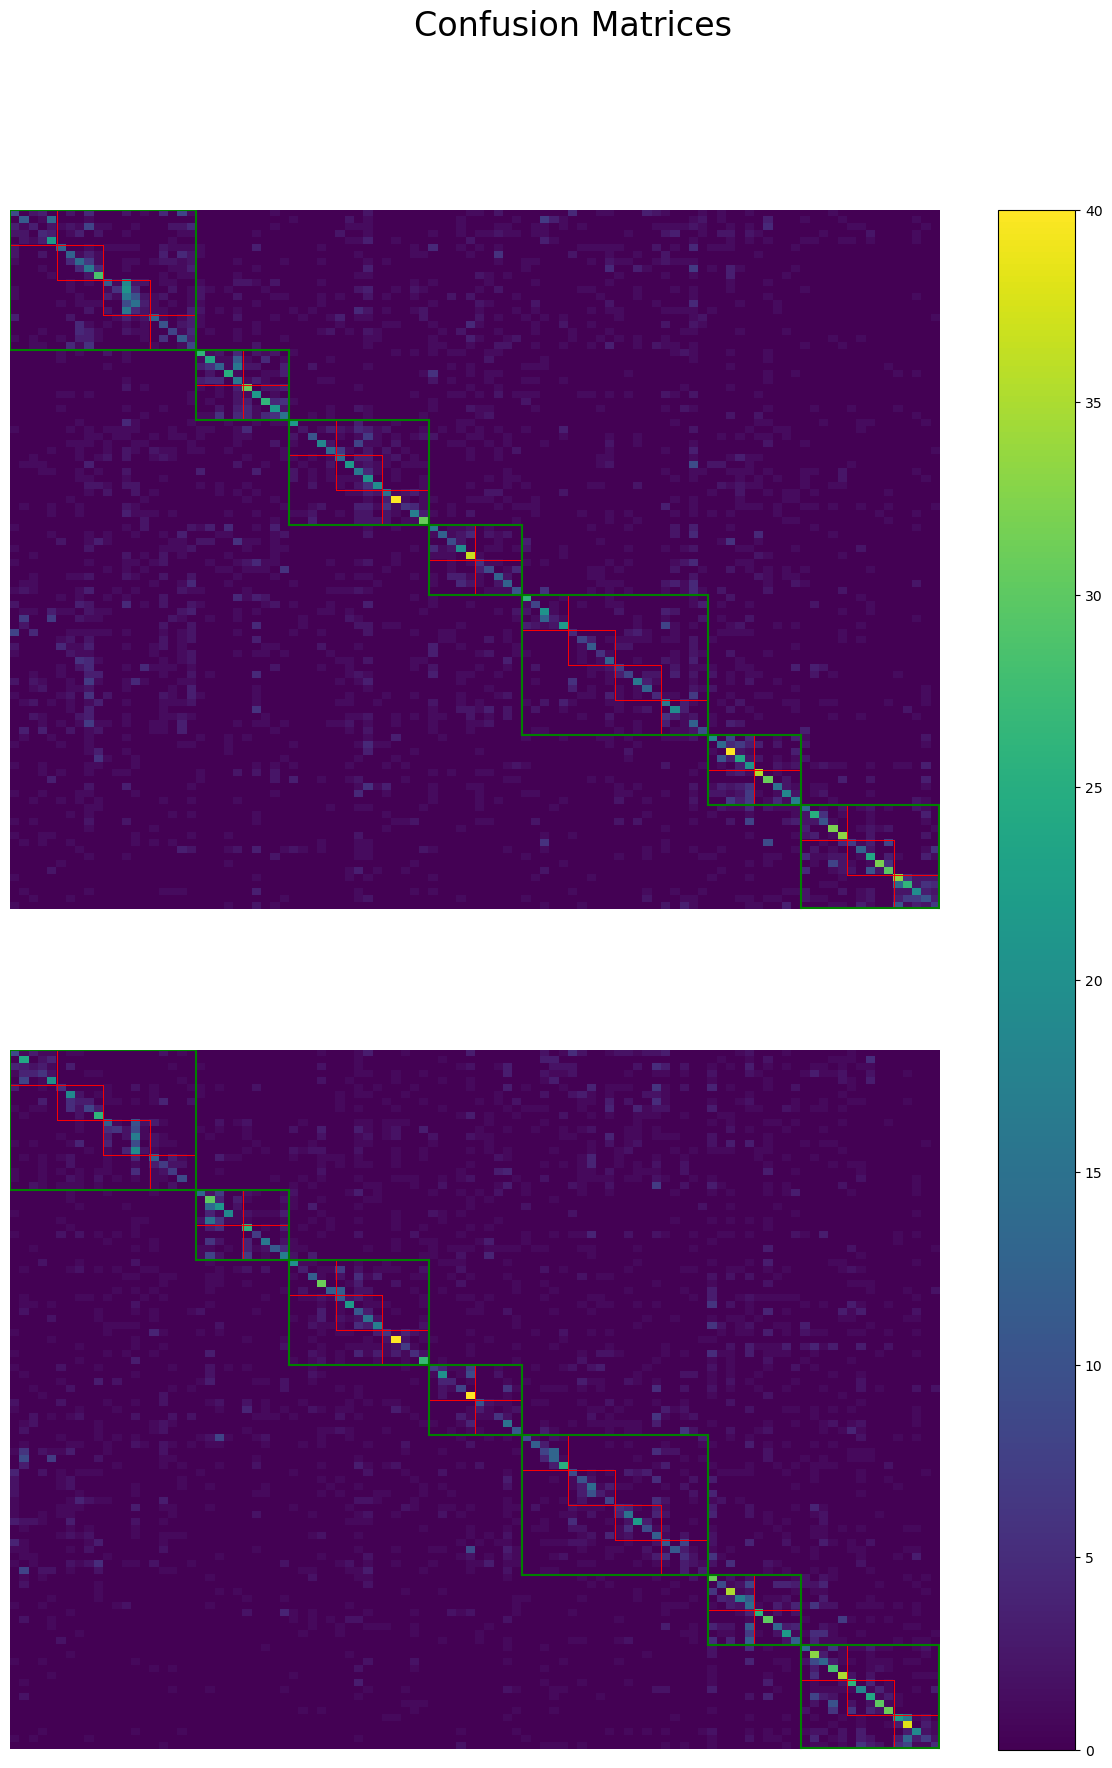

<Figure size 640x480 with 0 Axes>

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def class_max(input):
    return (torch.max(torch.exp(input), 1)[1]).data.cpu().numpy()

y_pred1 = []
y_true1 = []

y_pred2 = []
y_true2 = []

a=0

for inputs, labels in test_loader:
        trained_model1 = trained_model1.to("cpu")
        trained_model2 = trained_model2.to("cpu")
        
        labels = labels.numpy()
        
        output1 = trained_model1(inputs)
        output1 = class_max(output1)
        
        output2 = trained_model2(inputs)
        output2 = class_max(output2)
        
        y_pred1.extend(output1)
        y_true1.extend(labels)
    
        y_pred2.extend(output2)
        y_true2.extend(labels)
            
get_lab_vec = np.vectorize(get_labels)

classes = get_lab_vec(sorted_labels, "sub")

#I chose not to normalize so I get SE of two CMs
cm1 = confusion_matrix(y_true1, y_pred1
                       #, normalize="all"
                        ,labels = sorted_labels
                      )
cm2 = confusion_matrix(y_true2, y_pred2
                       #, normalize="all"
                        ,labels = sorted_labels
                      )

fig, axs = plt.subplots(2, 1, figsize = (15,20))
fig.suptitle('Confusion Matrices', fontsize=24)
axs[0].imshow(cm1, interpolation='none', aspect='auto')
#store for colorbar
im=axs[1].imshow(cm2, interpolation='none', aspect='auto')

#get the level via compact function
def get_super(i):
    return get_labels(create_superclass(i), "super")

def get_ultra(i):
    return get_labels(create_ultraclass(create_superclass(i)), "ultra")

#generator for section borders
def section_border_gen(get_level):
    #squares begin in the upper left corner 
    border_list=[-0.5]
    
    #get_level - get superclass or ultraclass from a subclass index
    state=get_level(sorted_labels[0])
    for i in range(len(sorted_labels)):
        current=get_level(sorted_labels[i])
        #if change in class at the given level - make a border
        if current!=state:
            border_list.append(i-0.5)
        state=get_level(sorted_labels[i])
    
    #smaller than 99.5 so that the line doesn't stand out from the graph
    border_list.append(99.35)
    
    return border_list

section_borders = [section_border_gen(get_super),section_border_gen(get_ultra)]
border_colors = ["red", "green"]
line_widths = [0.7, 1.5]

#level = the borders (at a given level - super/ultra)
#create 4 points to make a square
#draw lines between

for ax in axs:
    for level, color, line_width in zip(section_borders, border_colors, line_widths):
        for i, j in zip(level, level[1:]):
            points = [[i,i], [i,j], [j,j], [j,i]]

            for k, l in zip(points, points[1:]):
                ax.plot(k, l, color=color, linewidth=line_width)

            ax.plot(points[3], points[0], color=color, linewidth=line_width)

fig.colorbar(im, ax=axs.ravel().tolist())

for ax in axs:
    ax.axis('off')
    ax.grid(True)

plt.show()
plt.savefig('confusion1.png')

In [19]:
flat1 = cm1.flatten()
flat2 = cm2.flatten()

from sklearn.metrics import mean_squared_error

err = mean_squared_error(flat1, flat2)

In [20]:
err

1.483